# Principles of Array Optimization: From Bytecode to Assembly

In [24]:
import numpy as np
import random
import dis
import numexpr as ne
import jax
import jax.numpy as jnp
from jax import jit
import matplotlib.pyplot as plt

Introduction goes here

---

What happens in the following code?

In [2]:
a = np.array([1, 2, 3])
b = np.array([1, 2, 3])
c = np.array([1, 2, 3])
d = np.array([1, 2, 3])

e = a * b
f = e / c
g = f**d

If you've had some practice with NumPy before, you'll probably know about *Vectorized Array Operations*. These are a NumPy feature which allows NumPy to perform calculations on arrays much more quickly than we could with ordinary lists, not to mention being shorter and easier to read.

In [3]:
%%time

n = 1000

a_array= np.random.rand(n) * 100
b_array = np.random.rand(n) * 100
c_array = np.random.rand(n) * 100
d_array = np.random.rand(n)

a_list = list(a_array)
b_list = list(b_array)
c_list = list(c_array)
d_list = list(d_array)

CPU times: user 622 μs, sys: 843 μs, total: 1.47 ms
Wall time: 785 μs


In [4]:
%%time

# Using list comprehension

e_list = [a*b for a, b, in zip(a_list, b_list)]
f_list = [e/c for e, c, in zip(e_list, c_list)]
g_list = [f**d for f, d, in zip(f_list, d_list)]


CPU times: user 257 μs, sys: 12 μs, total: 269 μs
Wall time: 272 μs


In [5]:
%%time

# Using vectorized array operations

e_array = a_array * b_array
f_array = e_array / c_array
g_array = f_array**d_array

CPU times: user 201 μs, sys: 84 μs, total: 285 μs
Wall time: 248 μs


Now, looking at this you might wonder why I've split it up into three lines like this. Couldn't I do this all in one line? It'd be shorter, and probably faster too.

In [6]:
g_array = ((a_array * b_array)/c_array)**d_array

This version is indeed shorter, but it's actually not much faster. In fact, the differences should be almost undetectable.

Actually timing Python programs is difficult. There's a lot of unpredictability in how they run, so it's often more informative to look at what these programs produce!

## Introducing `dis`assembly

You may know that when Python code is run, it's turned into something called **bytecode**. Don't worry if you're not familiar with it, we're going to take a look at a simple example now!

The `dis` module, which is built into Python, can be used to 'disassemble' a function and see the bytecode it produces.

In [7]:
def foo(a_array, b_array, c_array, d_array):
    e_array = a_array * b_array
    f_array = e_array / c_array
    g_array = f_array**d_array
    
    return g_array

def bar(a_array, b_array, c_array, d_array):    
    g_array = ((a_array * b_array)/c_array)**d_array
    
    return g_array

print("DISASSEMBLED MULTI-LINE VERSION\n")
dis.dis(foo)

print("\nDISASSEMBLED SINGLE-LINE VERSION\n")
dis.dis(bar)

DISASSEMBLED MULTI-LINE VERSION

  1           0 RESUME                   0

  2           2 LOAD_FAST                0 (a_array)
              4 LOAD_FAST                1 (b_array)
              6 BINARY_OP                5 (*)
             10 STORE_FAST               4 (e_array)

  3          12 LOAD_FAST                4 (e_array)
             14 LOAD_FAST                2 (c_array)
             16 BINARY_OP               11 (/)
             20 STORE_FAST               5 (f_array)

  4          22 LOAD_FAST                5 (f_array)
             24 LOAD_FAST                3 (d_array)
             26 BINARY_OP                8 (**)
             30 STORE_FAST               6 (g_array)

  6          32 LOAD_FAST                6 (g_array)
             34 RETURN_VALUE

DISASSEMBLED SINGLE-LINE VERSION

  8           0 RESUME                   0

  9           2 LOAD_FAST                0 (a_array)
              4 LOAD_FAST                1 (b_array)
              6 BINARY_OP         

This is what Python code looks like under the hood!

Each line is a separate instruction telling Python what to do: `LOAD_FAST` and `STORE_FAST` are storing the addresses and names of the arrays, while all the math is done in the `BINARY_OP` step. 

The single-line version is shorter, but only by a few lines:

In [8]:
foo_set = set({
    "LOAD_FAST a_array",
    "LOAD_FAST b_array",
    "BINARY_OP *",
    "STORE_FAST e_array",

    "LOAD_FAST e_array", 
    "LOAD_FAST c_array",
    "BINARY_OP /",
    "STORE_FAST f_array",

    "LOAD_FAST f_array",
    "LOAD_FAST d_array",
    "BINARY_OP **",
    "STORE_FAST g_array",
})

bar_set = set({
    "LOAD_FAST a_array",
    "LOAD_FAST b_array",
    "BINARY_OP *",
    "LOAD_FAST c_array",
    "BINARY_OP /",
    "LOAD_FAST d_array",
    "BINARY_OP **",
    "STORE_FAST g_array",
})

print("Difference in the instructions:")
foo_set - bar_set

Difference in the instructions:


{'LOAD_FAST e_array',
 'LOAD_FAST f_array',
 'STORE_FAST e_array',
 'STORE_FAST f_array'}

The only difference here is that we're storing arrays e and f, which we do extremely quickly. All the hard work in `BINARY_OP` is shared.

In the multi-line version, the intermediary products of this array operation have names and remain available for us to examine. In the single line version, they're not given names and are quickly deleted. But we did create them!

Those of you with more experience in computer science may have already realized what this means: every single `BINARY_OP` allocates a new array onto the heap. 

If you're not familiar with the concepts of stack and heap, this summary will suffice for the moment: your computer has different regions of memory used for different kinds of work, and the two most common types are stack and heap. The stack is generally smaller, and working with it is extremely fast, but it's more restrictive. The heap has much more capacity, is slower, but can be used more freely. The stack's speed comes from its restrictions. 

Allocating new memory on the heap is one of the slower things modern computers do. Our judgment of speed is very relative. 'Slow' here is still very fast by human standards: it takes a few millionths of a second. But other things, like simple math, computers can do in **billionths of a second**.

One of the most common problems when optimizing code is making sure that the fast operations - like the math - aren't waiting ages and ages on something else - like memory allocation.

## Exploring `BINARY_OP`

## But what is an `np.ndarray`?

## Eliminating Intermediary Allocations

Despite all the work that `BINARY_OP` does, the allocation of new arrays is the most significant outside of actually doing the math. 

NumPy has to do this because of how it's designed (there are good reasons for this, which we don't have time to explore here), but we don't actually need it: we only care about the final output. Is there a way to do this while only allocating one array?

In theory, it shouldn't be hard. We could do something like this:

In [9]:
%%time 

out_array = np.zeros(n)

for i, (a_scalar, b_scalar, c_scalar, d_scalar), in enumerate(zip(a_array, b_array, c_array, d_array)):
    out_array[i] = ((a_scalar*b_scalar)/c_scalar)**d_scalar

CPU times: user 1.45 ms, sys: 30 μs, total: 1.48 ms
Wall time: 1.47 ms


We can define all our arrays, then allocate just one new array (defaulting to all zeros). Then we can iterate through all the arrays at the same time, pulling out the values one at a time, and doing the math on the scalars. This should work, right?

---

Well, yes, it will work. But it will also be **very slow**. Even slower than using list comprehension, despite the fact that we're iterating through arrays!

What's happening under the hood here?

Every single iteration, we have to extract the elements: these are coming from contiguous arrays, so we benefit from caching here, but each C float needs to be wrapped in an `np.float64` object, and then allocated onto the heap.

Yes, CS student, I see you. Yes, known-size scalar numeric types get allocated on the heap, not the stack. Welcome to Python.

Then we have to do all the same binary operation setup we saw before, but *on each element* rather than once per array, because Python doesn't know or care that these values originally came from a NumPy array: we're firmly in native-Python loop territory here, which means all of NumPy's nice guarantees are void and its optimizations are inaccessible.

Then, once we've actually gone ahead and done the math, producing the output, *that* needs to be transformed into a heap-allocated object too before being inserted to the array, where the vectorized operation could do this without the *per-element* intermediary allocation.

We've traded a handful of up-front allocations on a per-array basis with a lot more tiny allocations on a per-element basis. Since allocation time does **not** scale linearly with the size of the memory being allocated, this is a bad trade.

Oh, and there's also Python loop overhead that doesn't exist for the vectorized operations, which are also capable of SIMD optimizations that the native Python loop is a dozen layers away from being able to perform. We'll get into these details later, but just so you know.

---

Unfortunately, the easy, straightforward approach isn't viable. What other approaches can we take to speed this up?

## Approach 1: `NumExpr`

NumExpr is a Python library that solves exactly this kind of problem: 

In [10]:
%%time

def ne_evaluate(a, b, c, d):
    return ne.evaluate("((a*b)/c)**d")

res = ne_evaluate(a_array, b_array, c_array, d_array)

CPU times: user 641 μs, sys: 147 μs, total: 788 μs
Wall time: 815 μs


Instead of evaluating the expression eagerly like NumPy, NumExpr compiles the string expression into its own op-codes, which are then processed by a separate virtual machine outside of Python. It eliminates the intermediary allocations, making the process both faster and less costly in terms of memory. 

It also works in parallel, processing different regions of the array in different cores for an even larger speedup. 

However, there are some considerations. 

First, NumExpr is specifically designed to evaluate mathematical operations. It's very sophisticated, with support not just for regular arithmetic but for matrix operations, trigonometry, transcedental functions and complex numbers, so if your real-world problem does decompose into something like our example, then NumExpr should be your go-to. But if you need to make calls to other functions or perform other operations outside of NumExpr's domain, its utility drops off.

Second, NumExpr needs to work on large arrays to earn its keep. If you're working on arrays with fewer than 10e3 elements or so, NumExpr's setup cost (spinning up the virtual machine, acquiring locks on multiple cores, compiling the string operation) wind up slowing you down compared to the equivalent NumPy operation.

However, if you are working on large arrays, you can easily see 2-3x speedups compared to NumPy, even on simple operations like our `((a*b)/c)**d`: as the operation becomes more complex and the number of operations increases, expect that speedup to get larger and larger. 

## Approach 2: JIT Compilation: `Numba`/`JAX`

In [12]:
%%time

a_jarray = jnp.array(a_array)
b_jarray = jnp.array(b_array)
c_jarray = jnp.array(c_array)
d_jarray = jnp.array(d_array)

CPU times: user 23.3 ms, sys: 19.3 ms, total: 42.7 ms
Wall time: 69 ms


In [13]:
%%time

g_jarray = ((a_jarray * b_jarray)/c_jarray)**d_jarray

CPU times: user 62.9 ms, sys: 8.22 ms, total: 71.2 ms
Wall time: 68.8 ms


In [14]:
%%time

def bar(a_array, b_array, c_array, d_array):
    g_array = ((a_array * b_array)/c_array)**d_array
    return g_array

bar_compiled = jit(bar)

CPU times: user 168 μs, sys: 23 μs, total: 191 μs
Wall time: 189 μs


In [15]:
def numpy_array(a, b, c, d):
    return ((a*b)/c)**d

def jax_evaluate(a, b, c, d):
    a_jarray = jnp.array(a)
    b_jarray = jnp.array(b)
    c_jarray = jnp.array(c)
    d_jarray = jnp.array(d)

jax_evaluate = jit(numpy_array)


In [22]:
%%time

res = jax_evaluate(a_jarray, b_jarray, c_jarray, d_jarray)

CPU times: user 382 μs, sys: 166 μs, total: 548 μs
Wall time: 302 μs


In [90]:
%%time

res = bar_compiled(a_jarray, b_jarray, c_jarray, d_jarray)

CPU times: user 775 μs, sys: 341 μs, total: 1.12 ms
Wall time: 662 μs


---

!!!
JAX is bleeding-edge and very exciting. However, there are some caveats.

First, it's still in active development. It doesn't support all the operations you might want, though the gaps are being closed. Its support for 64-bit numbers remains shaky. In the attached benchmarking script, you'll note that the JAX results are tested to rtol 1e-6, while all the others are tested to 1e-9. 

It can also be nontrivial to set up on some machines, which can potentially lead to dependency and stability issues as time goes on.

Despite these issues, JAX is still very easy to use and quick to implement compared to the third and final approach we're about to take a look at: directly writing your own extensions in a low-level language like C or Rust.

---

## Approach 3: Low-level solutions

Sometimes, the best solution really is to leave Python and drop down to a lower-level language.

It's quite common, especially when writing code for high-performance libraries, to write code in a faster, compiled langauge and then let people call that code from Python. NumPy, NumExpr, JAX, and pretty much all high-performance numeric libraries have a core written in another language that's optimized for speed, and then a Python library is built around it.

The traditional choice for writing these libraries is the C programming language, or more rarely C++: however, these days more and more people are using Rust, because it is both fast and safe, and has a lot of nice, modern affordances. We'll go through an example of Rust-Python code here.

Note that in Rust, comments are written with `//`, not `#` like in Python!

```rust
// this is Rust's equivalent of Python's `import`
// we're importing pyo3, which makes writing Python+Rust code much easier,
// and also importing Rust's version of NumPy, which allows us to use NumPy functions from Rust
use pyo3::prelude::*;
use numpy::{PyArray1, PyReadonlyArray1, PyArrayMethods};

// this `pyfunction` decorator tells Rust that this function is meant to be called from Python
#[pyfunction]
// in Rust, the arguments of a function are inside parentheses `()` like in Python, the 
// type of the value being returned is after an arrow `->` and the body of the function is 
// inside braces `{}`
//
// ```
// fn foo() {
//    ...
// } 
// ```
// is the Rust equivalent of 
//
// ```
// def foo():
//     ...
// ```
//
// this defines a public function named `foo` that has access to the `'py` lifetime.
// 'public' just means the function can be exported to be used in other places.
// Lifetimes are an advanced Rust concept which we don't need to know about here. You
// can learn more about them at this link: https://doc.rust-lang.org/rust-by-example/scope/lifetime.html
pub fn foo<'py>(
    // we take Python itself as an argument. How this works is a bit complicated,
    // but it means this function will only run if Python is running. 
    // See the documentation here: https://docs.rs/pyo3/latest/pyo3/marker/struct.Python.html
    py: Python<'py>,
    // we take several NumPy arrays as arguments: in Rust, you *have* to put
    // the type of each argument after its name, and only one type is allowed!
    // this argument means 'a NumPy array of 64-bit floats that I promise not
    // to modify'
    a_arr: PyReadonlyArray1<f64>,
    b_arr: PyReadonlyArray1<f64>,
    c_arr: PyReadonlyArray1<f64>,
    d_arr: PyReadonlyArray1<f64>,

// this tells us what the function returns. You might have seen something similar in Python,
// but in Rust, the return signature is mandatory. This type signature means we're returning 
// one 1-d numpy array of 64-bit floats (equivalent to numpy's np.float64 type), and we're 
// giving it back to Python
) -> Bound<'py, PyArray1<f64>> {

    // take arrays as read-only slices
    let a_slice = a_arr.as_slice().unwrap();
    let b_slice = b_arr.as_slice().unwrap();
    let c_slice = c_arr.as_slice().unwrap();
    let d_slice = d_arr.as_slice().unwrap();

    // create a new NumPy array of the same length as the ones we took as arguments...
    let out_arr = unsafe { PyArray1::new(py, a_slice.len(), false)};
    // and take it as a mutable slice
    let out_slice = unsafe { out_arr.as_slice_mut().unwrap() };

    // both of the operations above are `unsafe`! This means that the computer cannot prove
    // they are safe, but we as programmers are telling it to chill out, we are
    // guaranteeing safety manually and taking responsibility in exchange for ignoring rules

    // our dumb loop goes through element by element, fusing the 
    // math operations into a single step without intermediate allocations
    // this is the same thing we tried to do earlier in Python!

    // Rust's syntax is messier, but this is the same as Python's
    // ```
    // for i, (a, b, c, d), in enumerate(zip(a_array, b_array, c_array, d_array)):
    // ```
    // we're zipping the arrays together, iterating through them, and taking
    // using one element from each at a time
    for (i, (((a, b), c), d)) in a_slice.iter()
        .zip(b_slice)
        .zip(c_slice)
        .zip(d_slice)
        .enumerate() {

        // this is just ((a*b)/c)**d: we do the math and load the result 
        // directly into the ith position in the out_slice
        out_slice[i] = ((a*b)/c).powf(*d);
    }
    // return the out array to Python - doesn't require a `return` keyword if it's 
    // the last thing in the function
    out_arr

    // we're done!
}
```

That was a lot! Despite how long this is, we've actually done quite little: unlike Python's operators or `BINARY_OP` instruction, which look simple on the surface but hide layers upon layers of checks, allocations, pointer chasing, and method calls, the code above is fairly low-level and a lot closer to 'what you see is what you get' (though even here, there are plenty of abstractions above machine code).

A lot of the code above, such as the `.as_slice().unwrap()`s, is just about type manipulation: it doesn't cause anything to actually *happen* when the code runs, but it proves that the code is safe *before* it runs.

In the end, what this does is quite simple: we get pointers to the start of these arrays, figure out how long they are, allocate a new array to hold the results (just one, no intermediate allocations) and then step through element by element, doing the calculation and writing the results to the existing array. 

If that sounds familiar, it's because that's exactly the kind of dumb-as-rocks loop we tried to build at the start of this notebook. The difference is that, now, it actually works as intended: there's no extra loop overhead, no allocation of scalar values, it's all happening on the stack. 

But don't take my word for it! Let's see the proof directly by learning to review x86 assembly.

## What is Assembly?

Assembly is the generic term for an instruction set that maps directly to electronic hardware. 

You're probably aware that, at the very bottom level, all data and software is represented by binary: strings of 1s and 0s. You may also have heard of logic gates: the physical systems inside electronic circuitry that modify binary. 

Assembly exists a level above that: assembly language commands a microchip to perform certain distinct, hardware-level actions, working directly with registers. Don't worry if you're not familiar with these, we'll cover the basics slowly.

In the modern day, it's quite rare for software engineers to directly write or even read assembly language - most don't know it at all and don't encounter after university. Even so, it remains very useful to be able to read assembly, in order to understand what a computer is actually doing. 

Rather than being written by hand, modern assembly is generated by compilers: programs that turn code into assembly. 

'Low-level' languages C and Rust compile directly to assembly... but even here, there's an intermediate step. Compilers generally turn written code into an intermediate representation (IR), which is then processed into assembly. 

What about 'higher level' languages like Python? Python (or at least, the most common Python engine) is written in C: this is called the [CPython API](https://docs.python.org/3/c-api/index.html). 

The bytecode we saw before is even higher-level: it coordinates calls to the CPython API. A bytecode instruction like BINARY_OP triggers a whole cascade of CPython API calls, which eventually bottom out in a series of assembly instructions, which direct the activity of logic gates burned into the hardware.

Lower <- Higher

Binary <- logic gates <- assembly <- LLVM IR <- C / Rust <- CPython API <- Bytecode <- Python

We've used the term 'low-level' before, but this term is very relative. Back in the 1970s, C was considered *high-level*! 

The reason going lower-level tends to lead to increased performance is that your intent gets more specific and there are fewer abstractions between your intent and the hardware. Fewer things that need to be checked at runtime, fewer layers of API calls. But the same code is less flexible and must be more verbose to communicate the same intent.

## Assembly Code Crash Course

Assembly is read line-by-line. Each line begins with a command, like `mov`, `call`, `add`, etc. Each command is followed by either one or two arguments. These arguments are either locations in memory described by a pointer `ptr`, or registers. 

Registers are special regions of memory that exist directly inside a microchip. This allows processors to access them extremely quickly and work with them directly. But they are also tiny. The largest registers can hold just 512 bits. 

The size of a register is described by the first letter of its name:

- `a`: 16-bit
- `e`: 32-bit
- `r`: 64-bit
- `xmm`: 128-bit (special purpose, introduced by SSE)
- `ymm`: 256-bit (special purpose, introduced by AVX)
- `zmm`: 512-bit (special purpose, introduced by AVX-512)

x86 assembly also describes memory sizes using 'words'.

- `word`: 16-bit
- `dword` or 'double-word': 32-bit
- `qword` or 'quad-word': 64-bit
- `xmmword`: 128-bit
- `ymmword`: 256-bit
- `zmmword`: 512-bit

Why are the word prefixes the same for some registers and not others? Legacy compatibility. Nobody designed it this way from the start. 

When there are two arguments after a command, they typically follow the format `command destination, source`. For example, if you have 64-bit numbers loaded into registers `r1` and `r2`, and you want to add them, you would use:

```
add     r1, r2
```

This will add the contents of `r1` and `r2`, and save the result to `r1`. The previous contents of `r1` are lost, unless deliberately backed up elsewhere.

## An Example of Assembly Code

Here's a modified version of the Python+Rust code we looked at before. This code is Rust-only, since [Compiler Explorer](https://godbolt.org) doesn't support `pyo3`.

```rust
pub fn foo(
    // `&[f64]` is a reference to an array of 64-bit floats
    a_arr: &[f64],
    b_arr: &[f64],
    c_arr: &[f64],
    d_arr: &[f64],
// the return type `Vec<f64>` is an owned array of 64-bit floats
) -> Vec<f64> {

    // note that we don't need to take a mutable slice here, because all these 
    // arrays are entirely in Rust-controlled memory.
    let mut out = vec![0.0; a_arr.len()];

    // otherwise, it's exactly the same!
    for (i, (((a, b), c), d)) in a_arr.iter()
        .zip(b_arr)
        .zip(c_arr)
        .zip(d_arr)
        .enumerate() {

        out[i] = ((a*b)/c).powf(*d);
    }
    out
}
```

---

With default settings, this function compiles to ~1700 lines of assembly. If we instead select the most aggressive optimization settings by passing the `-O` flag, it comes down to just over 150 lines!

But the part we care about is the vectorized loop, which is even shorter. Here is is in its entirety:

```
movupd  xmm1, xmmword ptr [r13 + r15]
movupd  xmm0, xmmword ptr [rbx + r15]
mulpd   xmm0, xmm1
movupd  xmm1, xmmword ptr [rcx + r15]
divpd   xmm0, xmm1
movapd  xmmword ptr [rsp + 80], xmm0
movups  xmm1, xmmword ptr [rdx + r15]
movaps  xmmword ptr [rsp + 96], xmm1
mov     r12, rbx
mov     rbx, rdx
call    rbp
movapd  xmmword ptr [rsp + 32], xmm0
movapd  xmm0, xmmword ptr [rsp + 80]
unpckhpd        xmm0, xmm0
movaps  xmm1, xmmword ptr [rsp + 96]
movhlps xmm1, xmm1
call    rbp
mov     rdx, rbx
mov     rbx, r12
mov     rcx, qword ptr [rsp + 24]
mov     rax, qword ptr [rsp]
movapd  xmm1, xmmword ptr [rsp + 32]
unpcklpd        xmm1, xmm0
movupd  xmmword ptr [rax + r15], xmm1
add     r15, 16
cmp     r14, r15
jne     .LBB0_9
mov     rsi, qword ptr [rsp + 56]
mov     rdi, qword ptr [rsp + 16]
```

## Breaking Down A Vectorized Loop in Assembly

Let's take this apart.

```
movupd  xmm1, xmmword ptr [r13 + r15]   ; load 2 doubles from array A
movupd  xmm0, xmmword ptr [rbx + r15]   ; load 2 doubles from array B
mulpd   xmm0, xmm1                      ; xmm0 = a * b (packed)
movupd  xmm1, xmmword ptr [rcx + r15]   ; load 2 doubles from array C
divpd   xmm0, xmm1                      ; xmm0 /= c (packed)
```

First, we load an `xmmword` from a memory location `ptr [r13 + r15]` into the `xmm1` register. Recall than `xmm` is 128 bits, so `xmmword ptr [r13 + r15]` means "the first 128 bits starting from the position `[r13+r15]`."

In terms of our program, this is loading the first two 64-bit numbers from array A into a 128-bit register.

We then do the same from `[rbx + r15]`, which is where we find of array B, loading the first two b values into the `xmm0` register.

The command used here is `movupd` (**mov**e **u**naligned **p**acked **d**oubles). A 'double' is another word for a 64-bit float, short for 'double-precision floating point': 32-bit floats are 'singles'. 

'Unaligned' in this context means that the data isn't guaranteed to start at an 8-byte boundary. We won't cover byte alignment, but you can find more information [here](https://en.wikipedia.org/wiki/Data_structure_alignment). 'Packed' means that they're smushed next to each other and being moved around as one unit. 

Once our As and Bs are in the registers, we can multiply them with `mulpd` (**mul**tiply **p**acked **d**oubles). This uses a single multiplication instruction to perform two multiplications, and store their results in xmm0. For a comparison to Python, imagine you had two tuples and multiplied them like so:

```python
a = (1.0, 3.5)
b = (8.0, 2.0)

b *= a

assert(b == (8.0, 7.0))
```

This doesn't actually work in Python, becaue tuples don't allow element-wise arithmetic (unless you use NumPy) but that's what's happening here!

We use the terminology 'lower' and 'upper' to refer to the first 64 and last 64 bits, respectively, in each register. 

What happens next?

We load two more doubles from *yet another* memory address into xmm1, this time corresponding to array C, and use `divpd` (**div**ide **p**acked **d**oubles), storing the result in xmm0, exactly the same way we did the multiplication.

This means that our loop is completing `(a*b)/c` in just five assembly instructions total... and that's for two elements at once, not one! This is the power of vectorized math operations: the same calculations, right at the assembly level, can be done in batches, making them twice as fast. 

This is obviously way better than our attempt at the same dumb loop in Python, since we're not performing so many implicit allocations each time, but it's also superior to NumPy's vectorized array operations on the same hardware: NumPy is also using vectorized instructions like `mulpd`, but it's doing all the multiplications, then a whole heap allocation, then all the divisions, while this implementation fuses the multiplication and division into the same iteration step.

---

Next, we have to perform the `**d` operation. This ends up being a good deal more complicated.

Elsewhere in the assembly code, we did this:

```
mov     rbp, qword ptr [rip + pow@GOTPCREL]
```

This **mov**es the 64-bit contents of `[rip + pow@GOTPCREL]` into the `rbp` register, which is typically used for 64-bit stack pointers. 

What in the world is `[rip + pow@GOTPCREL]`? It's Rust's built-in function for power operations! This will be important shortly.

```
movapd  xmmword ptr [rsp + 80], xmm0    ; xmm0 to local stack (16 bytes)
movups  xmm1, xmmword ptr [rdx + r15]   ; load 2 doubles from D
movaps  xmmword ptr [rsp + 96], xmm1    ; ... and then put them on the local stack, bc x86 doesn't allow mem-to-mem moves
mov     r12, rbx                        ; a little more juggling to save into callee-managed registers
mov     rbx, rdx
```

We now move use `movapd` (**mov**e *a*ligned **p**acked **d**oubles) to move the contents of `xmm0` (which right now contain the results of `(a*c)/c` for two elements) onto the stack. We do this to 'back them up' so to speak. 

We then load two doubles from array D into `xmm1`... and immediately move them onto the stack as well. This takes two instructions because x86 architecture does not allow us to move things from one point in memory to another point in memory: you have to put them in a register first. 

You'll notice we use a slightly different command, `movaps` (**mov**e *a*ligned **p**acked **s**ingles) instead of the doubles version. There are some cases where this would make a difference, but here it doesn't, and the compiler's choice to use one or the other is arbitrary.

We then move things around a bit more (I'm fond of calling this 'register juggling'), and we're finally ready for the main event:

```
call    rbp                             ; xmm0[0] ** xmm1[0]
```

The `call` command calls a function by taking a pointer to that function's location. Right now, the `rbp` register contains a power function, so `call    rbp` means 'raise the values in `xmm0` to the power of the values in `xmm1`'. 

You might ask "didn't we move the values of D out of `xmm1`? Shouldn't it be empty?" It's not, because the `mov` command and its variants do not destroy the original data - functionally, you should think of it as copying data, rather than moving it.

But there's a catch: Rust's power function works on just one set of 64-bit floats at a time. When we try to call it on a larger register, what does it do? It just uses the first 64 bits (aka the low bits) and ignores the rest. So what's happening here is more like

```python
xmm0 = (base1, base2)
xmm1 = (exponent1, exponent2)

xmm0 **= xmm1

assert(xmm0 = (result1, base2))
```

The Rust compiler doesn't have a built-in function for exponentiating packed doubles, and neither does x86 assembly. If we want to finish the job, we have to do some more juggling.

```
movapd  xmmword ptr [rsp + 32], xmm0    ; store result[0] on stack
movapd  xmm0, xmmword ptr [rsp + 80]    ; move previous (a*b)c/ back from stack
unpckhpd        xmm0, xmm0              ; shift higher bits to lower position
movaps  xmm1, xmmword ptr [rsp + 96]    ; do the same for xmm1
movhlps xmm1, xmm1
call    rbp                             ; xmm0[1] ** xmm1[1]
```

We're going to store the first result on the stack to avoid losing it. Then we're going to take the previous output we stored on the stack, which contains the lower and upper bits of `(a*b)/c`, and move it back into xmm0. 

Then we're going to use a neat trick: `unpckhpd` (**unp**a**ck** **h**igh **p**acked **d**oubles) takes the top 64 bits of xmm0, and *moves them down to replace the lower bits*. We do the same thing for `xmm1`, loading the previously stored values from array D, moving the high bits down, and using `call    rbp` again. 

And that's the important part! The rest of the assembly stores the results properly, inserts them into the output array, and sets up the next loop.

## Lessons and Benchmarking

That was a lot, especially if you haven't worked with assembly before. Take a break, drink some coffee or tea, and come back to this with some rest. From here, we're not writing more code (in any language), we're evaluating the results of the optimization.

### Bytecode vs Assembly

First, while it's still fresh in your mind, I want to compare the assembly we just examined with the bytecode we saw at the very beginning:

```
  2 LOAD_FAST                0 (a_array)
  4 LOAD_FAST                1 (b_array)
  6 BINARY_OP                5 (*)
 10 LOAD_FAST                2 (c_array)
 12 BINARY_OP               11 (/)
 16 LOAD_FAST                3 (d_array)
 18 BINARY_OP                8 (**)
 22 STORE_FAST               4 (g_array)
```

Load, load, op, load, op, load, op, return.

Conceptually, it's not so different from the assembly! After all, bytecode is itself a stack-based instruction set for orchestrating the actions of a lower-level programming construct.

But the assembly reflects commands to the hardware, each taking fractions of a nanosecond to complete and existing entirely on the stack, while the bytecode exists many layers of abstraction above the hardware, and each command hides multiple levels of pointer indirection, heap allocations, and type checks... which all eventually bottom out in assembly anyway.

This leads into an important lesson for optimization in general: the most *performant* solution is not necessarily the *optimal* solution. Our notions of optimization are conditioned not just on the performance characteristics of our software, but also the effort is takes to produce (and maintain) that software.

If you want to make something *as performant as possible*, then it will require a great deal of effort. However, this does not imply that performance scales linearly with effort. 

In [29]:

def plot_benchmark():
    labels = ["NumPy", "NumExpr", "JAX", "List Comprehension", "Dumb Loop",
              "Rust", "Rust+pow", "Rust+div+pow", "Rust+par", "Rust+par+pow", "Rust+par+pow_chunk"]

    data = [
        [10, 1.0, 0.172, 0.038, 0.538, 0.583, 1.447, 2.744, 1.893, 0.020, 0.045, 1.936],
        [20, 1.0, 0.186, 0.039, 0.389, 0.384, 1.581, 2.976, 1.962, 0.018, 0.053, 1.996],
        [50, 1.0, 0.196, 0.044, 0.220, 0.192, 1.606, 2.627, 1.898, 0.018, 0.051, 1.910],
        [100, 1.0, 0.220, 0.051, 0.136, 0.124, 1.541, 2.589, 1.857, 0.019, 0.055, 1.893],
        [200, 1.0, 0.288, 0.070, 0.092, 0.095, 1.100, 2.449, 1.946, 0.025, 0.070, 1.859],
        [500, 1.0, 0.383, 0.103, 0.065, 0.062, 1.051, 2.252, 1.742, 0.036, 0.099, 1.808],
        [1000, 1.0, 0.509, 0.172, 0.054, 0.052, 0.989, 2.215, 1.756, 0.062, 0.148, 1.878],
        [2000, 1.0, 0.628, 0.301, 0.054, 0.045, 0.980, 1.920, 1.652, 0.098, 0.227, 1.856],
        [5000, 1.0, 0.266, 0.615, 0.047, 0.041, 0.888, 1.980, 1.601, 0.200, 0.385, 1.841],
        [10000, 1.0, 0.618, 1.186, 0.050, 0.042, 0.935, 1.973, 1.786, 0.390, 0.759, 1.885],
        [20000, 1.0, 0.984, 1.931, 0.046, 0.038, 0.761, 1.727, 1.770, 0.612, 0.839, 1.787],
        [50000, 1.0, 1.883, 3.166, 0.048, 0.039, 0.829, 1.740, 1.807, 1.288, 1.219, 2.309],
        [100000, 1.0, 2.695, 3.473, 0.047, 0.039, 0.861, 1.656, 1.801, 1.968, 1.427, 3.498],
    ]

    arr = np.array(data)
    counts = arr[:, 0]

    fig, ax = plt.subplots(figsize=(12, 7))

    for i, label in enumerate(labels):
        ax.plot(counts, arr[:, i + 1], marker='o', markersize=4, label=label)

    ax.set_xscale('log')
    ax.set_xlabel('Count')
    ax.set_ylabel('Relative Time')
    ax.set_title('Benchmark Comparison')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

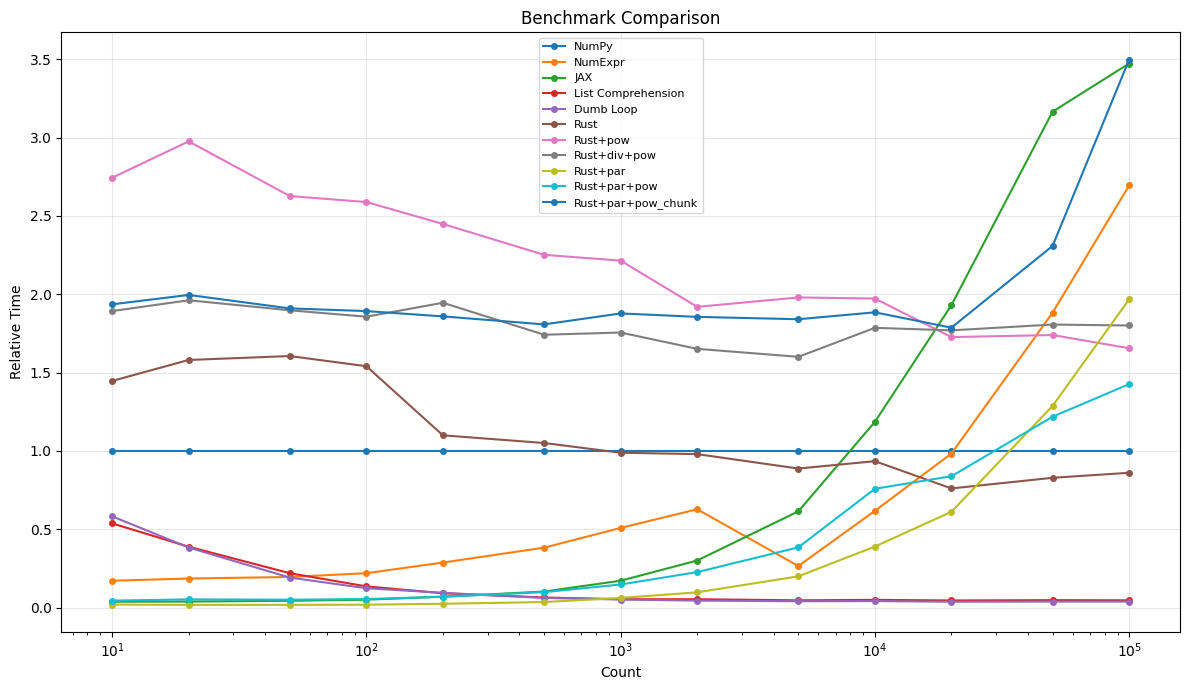

In [30]:
plot_benchmark()